<a href="https://colab.research.google.com/github/JairoRotava/Brazil-soils/blob/main/Colab/Exemplo_em_Colab_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exemplo utilização em Colab

In [ ]:
# Instala dependencias de funções GIS do R em Linux
system("apt-get -y update")
system("apt-get install -y libudunits2-dev libgdal-dev libgeos-dev libproj-dev")

In [ ]:
# Baixa dados do github
system('sudo git clone https://github.com/JairoRotava/Brazil-soils', intern=TRUE)
setwd("/content/Brazil-soils")
getwd()

character(0)

[1] "/content/Brazil-soils"

In [ ]:
# Instala pacotes. Demora pq eles são compilados...
install.packages("sf", lib="/content/Brazil-soils/Colab/compiled-packages")

In [ ]:
# Instala pacotes necessarios
install.packages(c("geobr","modules","sp"))

In [ ]:
install.packages(c("tryCatchLog", "futile.logger")")

In [ ]:
# Baixa dados do github
system('sudo git clone https://github.com/JairoRotava/Brazil-soils', intern=TRUE)

character(0)

In [ ]:
setwd("/content/Brazil-soils")
getwd()

[1] "/content/Brazil-soils"

In [ ]:
lib <- modules::use("R")

Masking (modules:dplyr):
  `intersect` from: base
  `setdiff` from: base
  `setequal` from: base
  `union` from: base

Masking (modules:sp):
  `merge` from: base
  `plot` from: base
  `split` from: base
  `summary` from: base

Loading required namespace: sf

Masking (modules:ggplot2):
  `as_label` from: modules:dplyr
  `enexpr` from: modules:dplyr
  `enexprs` from: modules:dplyr
  `enquo` from: modules:dplyr
  `enquos` from: modules:dplyr
  `ensym` from: modules:dplyr
  `ensyms` from: modules:dplyr
  `expr` from: modules:dplyr
  `Position` from: base
  `quo` from: modules:dplyr
  `quo_name` from: modules:dplyr
  `quos` from: modules:dplyr
  `sym` from: modules:dplyr
  `syms` from: modules:dplyr
  `vars` from: modules:dplyr



In [ ]:
# Processa/carregada dados embrapa
# ----
# Arquivo de dados pré processado embrapa
PRE_PROCESSED_FILE = "./results/embrapa_soil_raw.Rda"

# Caso arquivo de dados pré processado não existea, gera um a partir
# dos dados da embrapa
if (!file.exists(PRE_PROCESSED_FILE)) {
  print("Gerando arquivo de dados de embrapa")
  solos <- lib$embrapa$read_all_files("./Data/Embrapa")
  saveRDS(solos, PRE_PROCESSED_FILE)

}

# Carrega dados pré processados embrapa
# Ver variavel solos no RStudio
solos <- readRDS(PRE_PROCESSED_FILE)

Using year 2010



  |======================================================================| 100%


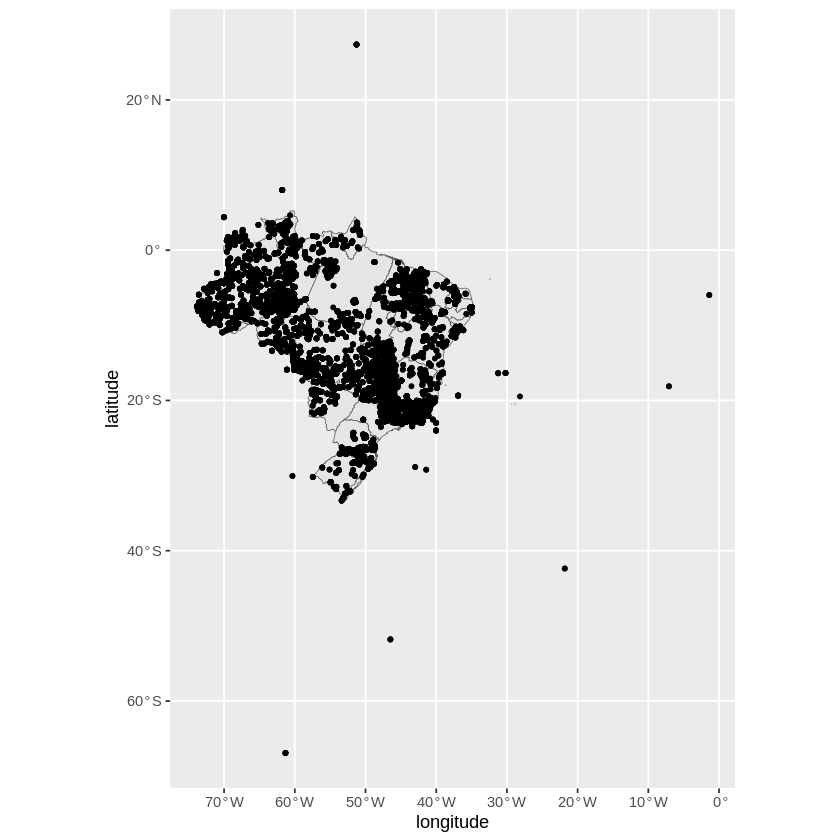

In [ ]:
# Mostra pontos no mapa
# ----

# Remove pontos sem coordenada GPS
solos = solos[complete.cases(solos[,c("latitude.graus",
                                      "longitude.graus")]),]
# Altera NA em coordenads GPS para 0, pois alguns pontos não tem
# segundos definidos
solos$latitude.graus[is.na(solos$latitude.graus)] <-0
solos$latitude.minutos[is.na(solos$latitude.minutos)] <-0
solos$latitude.segundos[is.na(solos$latitude.segundos)] <-0
solos$longitude.graus[is.na(solos$longitude.graus)] <-0
solos$longitude.minutos[is.na(solos$longitude.minutos)] <-0
solos$longitude.segundos[is.na(solos$longitude.segundos)] <-0

# Seta hemisferio para sul ou oeste sempre que tiver indefinido
solos$longitude.hemisferio <- tolower(solos$longitude.hemisferio)
solos$latitude.hemisferio <- tolower(solos$latitude.hemisferio)

solos$longitude.hemisferio[!(solos$longitude.hemisferio %in%
                               c("leste", "oeste"))] <- "oeste"
solos$latitude.hemisferio[!(solos$latitude.hemisferio %in%
                              c("norte", "sul"))] <- "sul"
# Como o brasil fica sempre a oeste, seta hemisferio
solos$longitude.hemisferio <- "oeste"


# Remove pontos com coordenadas GPS fora do range
solos = subset(solos, solos$longitude.graus <= 180
               & solos$longitude.graus >= -180)
solos = subset(solos, solos$latitude.graus <= 90
               & solos$latitude.graus >= -90)

# Converte latitude de graus para decimal
solos$lat_dec <- mapply(lib$embrapa$convert_deg_to_decimal,
                        solos["latitude.graus"],
                        solos["latitude.minutos"],
                        solos["latitude.segundos"],
                        solos["latitude.hemisferio"])

# Converte longitude de graus para decimal
solos$lon_dec <- mapply(lib$embrapa$convert_deg_to_decimal,
                        solos["longitude.graus"],
                        solos["longitude.minutos"],
                        solos["longitude.segundos"],
                        solos["longitude.hemisferio"])

# Converte latitudes positivas em negativas
#(erro no arquivo da embrapa),
#solos$lon_dec <- - abs(solos$lon_dec)

# Carrega mapa do Brasil para plotar os pontos de dados
lib$embrapa$plot_sites(solos$lon_dec, solos$lat_dec)


# Desenvolvimento conversao SWAT

In [ ]:
library(tryCatchLog)
library("futile.logger")
library(dplyr)

In [ ]:
# Converte para SWAT - Em desenvolvimento ainda!!!
# Utilizada dados pre processado Embrapa, processa dados e converte para SWAT
# ----

# Arquivo para log dos erros de conversao
LOG_FILE_NAME <- paste0("./log/",
                        format(Sys.time(), "%Y%m%dT%H%M%S"),
                        "_swat_convertion.log")


# tryLog insere muitas linhas no fim da mensagem
# foi criado um novo appender no futile.logger para remover as linhas extras
# do final. Se tiver mais de 3 fim de linha, troca por 1
my_appender <- function(filename)
{
  function(line) {
    appender.tee(filename)(gsub("\n\n\n+$", "\n", line) )
  }
}



SWAT_HEADER = c("MUID", "SEQN", "SNAM", "S5ID", "CMPPCT", "NLAYERS", "HYDGRP", "SOL_ZMX", "ANION_EXCL", "SOL_CRK", "TEXTURE",
                "SOL_Z1", "SOL_BD1", "SOL_AWC1", "SOL_K1", "SOL_CBN1", "CLAY1", "SILT1", "SAND1", "ROCK1", "SOL_ALB1", "USLE_K1", "SOL_EC1",
                "SOL_Z2", "SOL_BD2", "SOL_AWC2", "SOL_K2", "SOL_CBN2", "CLAY2", "SILT2", "SAND2", "ROCK2", "SOL_ALB2", "USLE_K2", "SOL_EC2",
                "SOL_Z3", "SOL_BD3", "SOL_AWC3", "SOL_K3", "SOL_CBN3", "CLAY3", "SILT3", "SAND3", "ROCK3", "SOL_ALB3", "USLE_K3", "SOL_EC3",
                "SOL_Z4", "SOL_BD4", "SOL_AWC4", "SOL_K4", "SOL_CBN4", "CLAY4", "SILT4", "SAND4", "ROCK4", "SOL_ALB4", "USLE_K4", "SOL_EC4",
                "SOL_Z5", "SOL_BD5", "SOL_AWC5", "SOL_K5", "SOL_CBN5", "CLAY5", "SILT5", "SAND5", "ROCK5", "SOL_ALB5", "USLE_K5", "SOL_EC5",
                "SOL_Z6", "SOL_BD6", "SOL_AWC6", "SOL_K6", "SOL_CBN6", "CLAY6", "SILT6", "SAND6", "ROCK6", "SOL_ALB6", "USLE_K6", "SOL_EC6",
                "SOL_Z7", "SOL_BD7", "SOL_AWC7", "SOL_K7", "SOL_CBN7", "CLAY7", "SILT7", "SAND7", "ROCK7", "SOL_ALB7", "USLE_K7", "SOL_EC7",
                "SOL_Z8", "SOL_BD8", "SOL_AWC8", "SOL_K8", "SOL_CBN8", "CLAY8", "SILT8", "SAND8", "ROCK8", "SOL_ALB8", "USLE_K8", "SOL_EC8",
                "SOL_Z9", "SOL_BD9", "SOL_AWC9", "SOL_K9", "SOL_CBN9", "CLAY9", "SILT9", "SAND9", "ROCK9", "SOL_ALB9", "USLE_K9", "SOL_EC9",
                "SOL_Z10", "SOL_BD10", "SOL_AWC10", "SOL_K10", "SOL_CBN10", "CLAY10", "SILT10", "SAND10", "ROCK10", "SOL_ALB10", "USLE_K10", "SOL_EC10")

convert_to_swat <- function(x) {
  soil_df <- data.frame(matrix(ncol = length(SWAT_HEADER), nrow = 1))
  colnames(soil_df) <- SWAT_HEADER
  # Obtem ID no ponto
  soil_df$MUID <- x[1,"codigo.pa"]
  flog.debug(paste("Processando ID ",soil_df$MUID))

  # Checa se não não existe valor NA como profundidade
  if (anyNA(x[c("profundidade.inferior","profundidade.superior")]))
  {
    stop(paste("Valores NA para profundida para ID", soil_df$MUID))

  }

  # Coloca em ordem crescente com profundidade
  x <- arrange(x, profundidade.superior)

  # numero de camadas
  # Trunca numero de camadas para 10 - limite SWAT
  n_layers <- nrow(x)
  if (n_layers > 10) {
    warning(paste("Truncando para 10 camadas de solo para ID", soil_df$MUID))
    n_layers <- 10
  }
  soil_df$NLAYERS <- n_layers
  # Verifica se espessuras de solo estao de acordo e atualiza
  z = 0


  # Varre camada por camada
  for (i in seq_len(n_layers)) {
    if (x[i,"profundidade.superior"] != z) {
      stop(paste("Erro de continuidade de camadas para ID",soil_df$MUID))
    }
    e <- x[i,"profundidade.inferior"] - x[i,"profundidade.superior"]
    z <- z + e
    soil_df[paste0("SOL_Z",i)] <- z

    # Fazer funcao PTF para a camada
    oc <- x[i,"carbono.organico"]
    clay <- x[i,"composicao.granulometrica.da.terra.fina.argila.g.kg"]/10
    silt <- x[i,"composicao.granulometrica.da.terra.fina.silte.g.kg"]/10
    sand <- x[i,"composicao.granulometrica.da.terra.fina.areia.total.g.kg"]/10
    rock <- x[i,"fracoes.da.amostra.total.calhaus.g.kg"]/10

    #print(paste(oc,clay,silt,sand,rock))
    # Calcula oq tem que calcular
    if (anyNA(c(oc, clay, silt, sand, rock))) {
      stop(paste("Dados de camada",i,"incompletos para ID", soil_df$MUID))
    }

    swat_layer <- lib$soil$convert_layer_to_swat(oc, clay, silt, sand, rock)


    soil_df[paste0("SOL_BD",i)] <- swat_layer$SOL_BD
    soil_df[paste0("SOL_AWC",i)] <- swat_layer$SOL_AWC
    soil_df[paste0("SOL_K",i)] <- swat_layer$SOL_K
    soil_df[paste0("SOL_CBN",i)] <- swat_layer$SOL_CBN
    soil_df[paste0("CLAY",i)] <- swat_layer$CLAY
    soil_df[paste0("SILT",i)] <- swat_layer$SILT
    soil_df[paste0("SAND",i)] <- swat_layer$SAND
    soil_df[paste0("ROCK",i)] <- swat_layer$ROCK
    soil_df[paste0("SOL_ALB",i)] <- swat_layer$SOL_ALB
    soil_df[paste0("USLE_K",i)] <- swat_layer$USLE_K
    soil_df[paste0("SOL_EC",i)] <- swat_layer$SOL_EC

  }
  soil_df$SOL_ZMX <- z

  # ANION_EXC. Default value if this parameter is not available
  soil_df$ANION_EXCL <- 0.5
  #sOL_CRK. Set to same value as all the existing soils in the APEX database
  soil_df$SOL_CRK <- 0.5

  return(soil_df)
}


# Obtem ID unicos dos pontos da coluna "codigo.pa"
ids <- unique(solos$codigo.pa)

# Para DEBUG é interessante diminuir o numero de pontos, por isso
# seleciona somente alguns ids.
#ids <- c(7081, 7082, 7086)
ids <- ids[1:10]

flog.appender(my_appender(LOG_FILE_NAME))
flog.threshold(DEBUG)
#swat_soil <- data.frame()
swat_soil <- data.frame(matrix(ncol = length(SWAT_HEADER), nrow = 1))
colnames(swat_soil) <- SWAT_HEADER

# Converte dados embrapa para formato SWAT. Gera log
for (id in ids) {
  df = solos %>% filter(codigo.pa == id)

  #try({
  #  converted_soil <- lib$embrapa$convert_to_swat(df)
  #  swat_soil <- rbind(swat_soil, converted_soil)
  #})

  # tryLog tenta realizar conversão, e gera log com erros para posterior verificação
  tryLog(
    {
      converted_soil <- convert_to_swat(df)
      swat_soil <- rbind(swat_soil, converted_soil)
    },
    include.compact.call.stack = FALSE,
    include.full.call.stack = FALSE,
  )
}

# Salva arquivo de solos para SWAT
FILE_OUT = "./results/soil_brazil.csv"
write.csv(swat_soil,FILE_OUT, quote = FALSE, row.names = FALSE)

NULL

NULL

DEBUG [2024-03-03 20:08:03] Processando ID  5768
ERROR [2024-03-03 20:08:03] Erro de continuidade de camadas para ID 5768
DEBUG [2024-03-03 20:08:03] Processando ID  5769
ERROR [2024-03-03 20:08:03] Erro de continuidade de camadas para ID 5769
DEBUG [2024-03-03 20:08:03] Processando ID  5771
ERROR [2024-03-03 20:08:03] Erro de continuidade de camadas para ID 5771
DEBUG [2024-03-03 20:08:03] Processando ID  5772
ERROR [2024-03-03 20:08:03] Erro de continuidade de camadas para ID 5772
DEBUG [2024-03-03 20:08:03] Processando ID  5773
ERROR [2024-03-03 20:08:03] Erro de continuidade de camadas para ID 5773
DEBUG [2024-03-03 20:08:03] Processando ID  5774
ERROR [2024-03-03 20:08:03] Erro de continuidade de camadas para ID 5774
DEBUG [2024-03-03 20:08:03] Processando ID  5775
ERROR [2024-03-03 20:08:03] Erro de continuidade de camadas para ID 5775
DEBUG [2024-03-03 20:08:03] Processando ID  5776
ERROR [2024-03-03 20:08:03] Erro de continuidade de camadas para ID 5776
DEBUG [2024-03-03 20:08: